In [ ]:
# 95% categories, less layers

In [ ]:
#docker run -it --rm -v c:/workspace/jupyter:/tf -p 8888:8888 tensorflow/tensorflow:latest-gpu-jupyter
#2021-01-05
#!pip install pandas
#!pip install tensorflow_hub
#!pip install tensorflow_text
#!pip install tensorflowjs

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf

np.set_printoptions(precision=3, suppress=True) # easy to read read only

from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Activation, Dense, Embedding, GlobalAveragePooling1D
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import json
import re

In [3]:
print("Version: ", tf.__version__)
raw_data = pd.read_csv('data/S_SURVEY_FULL.csv')
# raw_data.head()



Version:  2.4.0


In [4]:
# features / labels / Y
_cat_list = list()
_min_num = len(raw_data) * .05

for c in list(raw_data.columns)[1:(len(raw_data.columns)-1)]:
    if(raw_data[[c]].sum().tolist()[0] > _min_num):
        _cat_list.append(c)
expect = raw_data.loc[:, _cat_list]
Y = np.array(expect)
feature = np.array(raw_data.loc[:,['JSON']]).reshape(-1)
print(feature.shape,len(_cat_list))

(2543,) 46


In [5]:
# train / text / X
VOCAB_SIZE=400
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE)
ff = np.array([re.sub('[^0-9a-zA-Z_\\.]+', ' ', xx) for xx in feature])
encoder.adapt(ff)
print(np.array(encoder.get_vocabulary()).shape, len(encoder.get_vocabulary()))
print(ff.shape,Y.shape)

(400,) 400
(2543,) (2543, 46)


In [6]:
output_den = len(Y[0]);

model = tf.keras.Sequential()
model.add(encoder)

model.add(tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary()),mask_zero=True,
                                    output_dim=16))
# model.add(tf.keras.layers.LSTM(64))

model.add(tf.keras.layers.Dense(256, activation='relu'))

# model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Dense(128, activation='tanh'))
model.add(tf.keras.layers.GlobalAveragePooling1D())
model.add(tf.keras.layers.Dense(output_den, activation='sigmoid'))


# # model.summary()
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(x=ff,y=Y,
                    epochs=1,batch_size=512,
                    validation_split=0.01,
                     verbose=1,
#                      callbacks=[cp_callback],
                    use_multiprocessing=True
                   )

5/5 [==============================] - 3s 346ms/step - loss: 0.6902 - accuracy: 0.0082 - val_loss: 0.6803 - val_accuracy: 0.0000e+00


In [7]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(x=ff,y=Y,
                    epochs=1,batch_size=512,
                    validation_split=0.01,
                     verbose=1,
#                      callbacks=[cp_callback],
                    use_multiprocessing=True
                   )

5/5 [==============================] - 2s 301ms/step - loss: 0.6744 - accuracy: 0.0231 - val_loss: 0.6572 - val_accuracy: 0.0000e+00


In [8]:
checkpoint_path = "../checkpoint/survey_short_full_v2.ckpt"

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=0)

def plotHistory(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

Epoch 1/70
5/5 [==============================] - 1s 231ms/step - loss: 0.6399 - accuracy: 0.0262 - val_loss: 0.6193 - val_accuracy: 0.0000e+00
Epoch 2/70
5/5 [==============================] - 1s 225ms/step - loss: 0.5870 - accuracy: 0.0262 - val_loss: 0.5629 - val_accuracy: 0.0000e+00
Epoch 3/70
5/5 [==============================] - 1s 211ms/step - loss: 0.5117 - accuracy: 0.0262 - val_loss: 0.4985 - val_accuracy: 0.0000e+00
Epoch 4/70
5/5 [==============================] - 1s 199ms/step - loss: 0.4294 - accuracy: 0.0262 - val_loss: 0.4599 - val_accuracy: 0.0000e+00
Epoch 5/70
5/5 [==============================] - 1s 219ms/step - loss: 0.3766 - accuracy: 0.0262 - val_loss: 0.4768 - val_accuracy: 0.0000e+00
Epoch 6/70
5/5 [==============================] - 1s 224ms/step - loss: 0.3669 - accuracy: 0.0262 - val_loss: 0.5091 - val_accuracy: 0.0000e+00
Epoch 7/70
5/5 [==============================] - 1s 234ms/step - loss: 0.3665 - accuracy: 0.0262 - val_loss: 0.5124 - val_accuracy: 0.0

5/5 [==============================] - 1s 212ms/step - loss: 0.3075 - accuracy: 0.0262 - val_loss: 0.4632 - val_accuracy: 0.0000e+00
Epoch 58/70
5/5 [==============================] - 1s 236ms/step - loss: 0.3068 - accuracy: 0.0267 - val_loss: 0.4631 - val_accuracy: 0.0000e+00
Epoch 59/70
5/5 [==============================] - 1s 208ms/step - loss: 0.3062 - accuracy: 0.0267 - val_loss: 0.4603 - val_accuracy: 0.0000e+00
Epoch 60/70
5/5 [==============================] - 1s 218ms/step - loss: 0.3055 - accuracy: 0.0267 - val_loss: 0.4593 - val_accuracy: 0.0000e+00
Epoch 61/70
5/5 [==============================] - 1s 222ms/step - loss: 0.3048 - accuracy: 0.0262 - val_loss: 0.4581 - val_accuracy: 0.0000e+00
Epoch 62/70
5/5 [==============================] - 1s 212ms/step - loss: 0.3042 - accuracy: 0.0267 - val_loss: 0.4599 - val_accuracy: 0.0000e+00
Epoch 63/70
5/5 [==============================] - 1s 202ms/step - loss: 0.3037 - accuracy: 0.0267 - val_loss: 0.4634 - val_accuracy: 0.0000e+

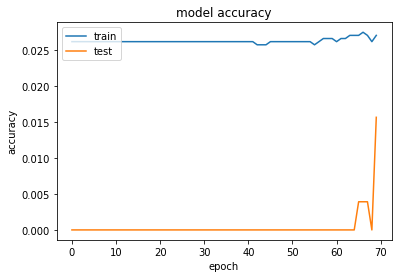

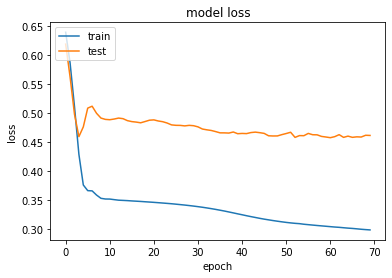

In [9]:
history = model.fit(x=ff,y=Y,
                    epochs=70,batch_size=512,
                    validation_split=0.1,
                     verbose=1,
                     callbacks=[cp_callback],
                    use_multiprocessing=True
                   )

plotHistory(history)

In [ ]:
history = model.fit(x=ff,y=Y,
                    epochs=2000,batch_size=512,
                    validation_split=0.1,
                     verbose=1,
#                      callbacks=[cp_callback],
                    use_multiprocessing=True
                   )

80/80 [==============================] - 0s 6ms/step - loss: 0.1132 - accuracy: 0.1066


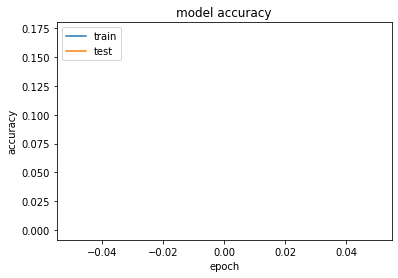

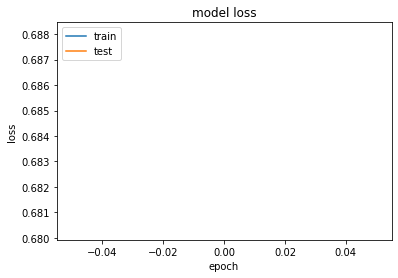

In [9]:
model.evaluate(ff,Y)
plotHistory(history)

In [8]:
model.load_weights(checkpoint_path)
# model.save_weights(checkpoint_path)


In [10]:
all_predict=model.predict(ff[:])
error_matrix=(np.absolute(Y - all_predict) > .5).astype(int)
_total = error_matrix.sum()
print(_total, len(Y), _total / len(Y), _total / len(Y) / len(Y[0]))
print(np.average(error_matrix.sum(axis=1) / len(Y[0])))

5313 2543 2.0892646480534802 0.04541879669681479
0.045418796696814784


In [ ]:
full_expect = raw_data[raw_data.columns[1:(len(raw_data.columns)-1)]]
np_pred = (all_predict > 0.5).astype(int)
full_predict = full_expect.copy()
for idx, name in enumerate (_cat_list) :
    full_predict[name] = np_pred[:,idx]
full_predict = full_predict[full_expect.columns]
full_error=np.absolute(np.array(full_expect) - np.array(full_predict))
_total = full_error.sum()
print('Wrong:', _total, len(full_error), 'Wrong in row:', _total / len(full_error), _total / len(full_error) / len(full_error[0]))

In [ ]:
import tensorflowjs as tfjs

tfjs.converters.save_keras_model(model, '../checkpoint/js')